In [12]:
variant = ord('H') % 5 + 1
print(f"Variant: {variant}") 

Variant: 3


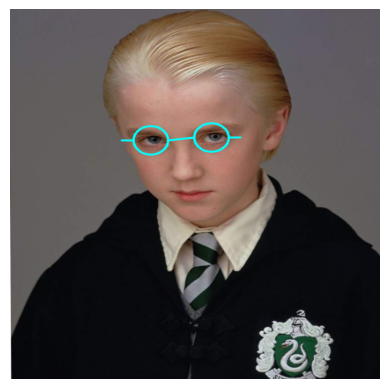

In [13]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

colors = {
    "red": (0, 0, 255),
    "blue": (255, 0, 0),
    "yellow": (0, 255, 255),
    "cian": (255, 255, 0),
    "magenta": (255, 0, 255),
}


def find_suitable_eyes(eyes):
    if len(eyes) < 2:
        return None  # Not enough eyes to compare

    min_diff = 5
    closest_pair = None

    for i in range(len(eyes)):
        for j in range(i + 1, len(eyes)):
            diff = abs(eyes[i][2] - eyes[j][2])  # Compare areas
            if diff < min_diff:
                min_diff = diff
                closest_pair = (eyes[i], eyes[j])

    pair = (
        (closest_pair[0][0], closest_pair[0][1]),
        (closest_pair[1][0], closest_pair[1][1]),
    )

    if pair[0][0] < pair[1][0]:
        return (pair[0], pair[1])
    else:
        return (pair[1], pair[0])


def add_glasses(image_path, image_size, glasses_color, line_width):
    image = cv2.imread(image_path)

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
    faces = face_cascade.detectMultiScale(image_gray, 1.3, 5)

    for x, y, w, h in faces:
        face_rect = image_gray[y : y + h, x : x + w]
        eyes = eye_cascade.detectMultiScale(face_rect)
        eye_centers = []

        radius = 0
        for ex, ey, ew, eh in eyes:
            eye = (x + ex + ew // 2, y + ey + eh // 2, ew // 2)
            radius += int(ew / 2)
            eye_centers.append(eye)
        radius = int(radius / len(eyes))  # average eye radius

        if len(eye_centers) >= 2:
            (eye1, eye2) = find_suitable_eyes(eye_centers)

            cv2.circle(image, eye1, radius, glasses_color, line_width)
            cv2.circle(image, eye2, radius, glasses_color, line_width)

            cv2.line(  # between eyes
                image,
                (eye1[0] + radius, eye1[1]),
                (eye2[0] - radius, eye2[1]),
                glasses_color,
                line_width,
            )

            cv2.line(
                image,
                (eye1[0] - radius, eye1[1]),  # start
                (
                    eye1[0] - int(1.7 * radius),
                    eye1[1],
                ),  # end (braket lenght depends on radius)
                glasses_color,
                line_width,
            )
            cv2.line(
                image,
                (eye2[0] + radius, eye2[1]),
                (eye2[0] + int(1.7 * radius), eye2[1]),
                glasses_color,
                line_width,
            )
    return cv2.resize(image, image_size)


df = pd.read_excel("kr1.xlsx")


row = df[df["N"] == variant].iloc[0]
image_path = "images/" + row["file name"]
image_size = tuple(map(int, row["image size"].split("x")))
glasses_color = colors[row["glasses color"]]
line_width = int(row["line width"])  # brg

img = add_glasses(image_path, image_size, glasses_color, line_width)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis("off")  # Turn off axis
plt.show()  # Display the image
